# Membaca data

In [1]:
from jupyter_lstm import read_data 

DataSahamStr = 'SMGRW.csv'

data = read_data.readData(DataSahamStr)

training_data  [[2.0140109e+07 1.4100000e+04]
 [2.0140110e+07 1.4900000e+04]
 [2.0140113e+07 1.5525000e+04]
 ...
 [2.0200106e+07 1.2275000e+04]
 [2.0200107e+07 1.2300000e+04]
 [2.0200108e+07 1.2000000e+04]]


# Inisial variable untuk input LSTM

In [2]:
# I_SequenceLength = int(input("masukkan panjang memory: "))
I_SequenceLength = 5
print ("Panjang memory(sequenceLength) adalah %s" %I_SequenceLength)
sequenceLength = I_SequenceLength

# numEpochs = int(input("masukkan banyak epoch : "))
numEpochs = 10
print ("banyak epoch adalah %s" %numEpochs)

data_saham_Normalisasi = data[0]

# rate = float(input("masukkan learning rate : "))
rate = 0.3
print ("Learnig rate adalah %s" %rate)

Panjang memory(sequenceLength) adalah 5
banyak epoch adalah 10
Learnig rate adalah 0.3


# Persiapan Data 

In [3]:
# skenarioI = int(input("masukkan skenario pilihan : "))
skenarioI = 2
print (data_saham_Normalisasi)

# sebelum digabungkan 1 = [0.00000000e+00 4.32551320e-01]
import numpy as np
data_saham_Normalisasi = np.concatenate((np.ones((data_saham_Normalisasi.shape[0], 1)), data_saham_Normalisasi), axis=1)
# setelah digabungkan 1 = [1.00000000e+00 0.00000000e+00 4.32551320e-01]

# pembagian skenario
skenarioP = read_data.bagi_data(skenarioI,data_saham_Normalisasi)
print ("banyak data training : ",len(skenarioP[0]))
training_Data = skenarioP[0]

print ("banyak data testing : ",len(skenarioP[1]))
testing_Data = skenarioP[1]

[[0.00000000e+00 4.32551320e-01]
 [4.95046858e-08 4.79472141e-01]
 [1.98018743e-07 5.16129032e-01]
 ...
 [2.97013263e-03 3.25513196e-01]
 [2.97018214e-03 3.26979472e-01]
 [2.97023164e-03 3.09384164e-01]]
banyak data training :  999
banyak data testing :  500


# Generator untuk memotong data sesuai squencial 

In [42]:
import random
def sequenceProducer(trainingData, sequenceLength):
    indices = [i for i in range(0, trainingData.shape[0] - sequenceLength + 1, sequenceLength)]
    random.shuffle(indices)
    for index in indices:
        yield trainingData[index:index + sequenceLength]

a = []
for r in range(1,100):
    a.append(r)

b = sequenceProducer(a, 5)
for t in range(1,20):
    print (next(b))

In [43]:
def forecastSequenceProducer(trainingData, sequenceLength):
    for i in range(trainingData.shape[0] - sequenceLength + 1):
        yield trainingData[i:i + sequenceLength]

c = []
for r in range(1,100):
    c.append(r)

d = forecastSequenceProducer(c, 5)
for t in range(1,20):
    print (next(d))

# LSTM

In [44]:
from jupyter_lstm import LSTM

ukuran_input = data_saham_Normalisasi.shape[1]
ukuran_output = data_saham_Normalisasi.shape[1]-2
bobot = [[-0.245714286	,0.850360602	,0.029262045	,0.184398087]
        ,[0.868020398	,0.860429754	,-0.379580925	,0.079506914]
        ,[-0.206444161	,-0.24856166	,-0.085253247	,0.25112624	]
        ,[0.842874383	,-0.324206065	,0.907722829	,-0.593738792]]
print ("Ukuran Input ",ukuran_input)
print ("Ukuran Output ",ukuran_output)
print ("Ukuran bobot ",bobot)
lstm = LSTM.LSTMCell(ukuran_input, ukuran_output,bobot)

Ukuran Input  3
Ukuran Output  1
Ukuran bobot  [[-0.245714286, 0.850360602, 0.029262045, 0.184398087], [0.868020398, 0.860429754, -0.379580925, 0.079506914], [-0.206444161, -0.24856166, -0.085253247, 0.25112624], [0.842874383, -0.324206065, 0.907722829, -0.593738792]]


### LSTM Training

In [45]:
import pandas as pd
adaptiveLearningRate = rate
for epoch in range(numEpochs):
    trainingSequences = sequenceProducer(training_Data, sequenceLength) #data training 
    epochError = 0.0
    counter = 0
    for sequence in trainingSequences:
        counter += 1
        # proses forward
        lstm.forwardPass(sequence[:-1])
        
        # proses backward 
        result = lstm.BPTT(sequence[1:,2:])
        
        # hasil error yang dihasilkan backword
        E = result[0]
        
        # hasil turunan bobot dihasilkan backword
        dE_dW = result[1]
        w = dE_dW.shape
        
        # Annealing () Optimasi
        adaptiveLearningRate = rate / (1 + (epoch/10))
        lstm.W = lstm.W - adaptiveLearningRate * dE_dW
        epochError += E
    
    print('Epoch ' + str(epoch) + ' error: ' + str(epochError / counter))

Epoch 0 error: 0.04170492622656841
Epoch 1 error: 0.01770343944632908
Epoch 2 error: 0.012893017038793825
Epoch 3 error: 0.011015536285281194
Epoch 4 error: 0.009770459612413575
Epoch 5 error: 0.00909014536839328
Epoch 6 error: 0.00827596972152922
Epoch 7 error: 0.007505953465796842
Epoch 8 error: 0.007270178666289527
Epoch 9 error: 0.006974841426888338


### LSTM Testing

In [46]:
import pandas as pd

max_ex = data[1]
min_ex = data[2]

# Memotong data sesuai dengan panjang data atau squeneLength 
forecastSequences = forecastSequenceProducer(testing_Data, sequenceLength)

# Data Real
labels = []

# Data Preiksi
forecasts = []

forecastError = 0.0
forecastError_MSE = 0.0
forecastError_MAPE = 0.0
countForecasts = 0

data_full_csv = {}
data_perhitungan = pd.DataFrame(data_full_csv) # df 

for sequence in forecastSequences: 
        countForecasts += 1
        forecast  = lstm.forwardPass(sequence[:-1])
        # data_sequence_close_NT = sequence[:,2:]
        
        # sequenceNT = LSTM.denormal(sequenceLength,sequence,max_ex,min_ex)

        # ----------------------- proses pemasukan excel ---------------------------

        # -------- gat perhitungan manual forward ------
        f_l     = np.transpose(np.transpose(forecast[0]))
        f_z     = np.transpose(np.transpose(forecast[1]))
        f_c     = np.transpose(np.transpose(forecast[2]))
        f_o     = np.transpose(np.transpose(forecast[3]))
        f_f     = np.transpose(np.transpose(forecast[4]))
        f_i     = np.transpose(np.transpose(forecast[5]))
        f_c_bar = np.transpose(np.transpose(forecast[6]))
        f_h     = np.transpose(np.transpose(forecast[7]))
        f_W     = np.transpose(np.transpose(forecast[8]))
        # ----------------------------------------------

        R  = forecast[-1]

        # block proses lstm 
        list_table_hitung = [f_l.tolist(),f_z.tolist(),f_c.tolist()
                            ,f_o.tolist(),f_f.tolist(),f_i.tolist()
                            ,f_c_bar.tolist(),f_h.tolist(),f_W.tolist()]
        
        list_table_hitung_str = ["I","Z","C","O","F","I_in","C_bar","h","W"]
        
        # dimasukkan ke excel 
        data_perhitungan_new = LSTM.ex_excel(list_table_hitung,list_table_hitung_str)
        data_perhitungan = pd.concat([data_perhitungan_new, data_perhitungan]).reset_index(drop = True) 
        # --------------------------------------------------------------------------

        # Denormalisasi Prediksi
        V_Predict = forecast[0]
        V_Predict *= max_ex[1:]
        V_Predict += min_ex[1:]

        forecasts.append(V_Predict)
        
        # Denormalisasi label
        label = sequence[-1,2:] * max_ex[1:]
        label += min_ex[1:]
        labels.append(label)

        # Error (target - prediksi)
        print('Error: ' + str(np.absolute( label[-1]-V_Predict[-1] )))

        forecastError += np.absolute(label[-1]-V_Predict[-1])
        
        forecastError_MSE += (np.absolute(label[-1]-V_Predict[-1]))**2
        
        # print_sequence(sequence,max_ex,min_ex)

# Export to csv 
data_perhitungan.to_csv("datatata.csv") # block preses

69450156]
Error: [14475.          2557.19044175     0.            16.56666937]
Error: [14475.          2557.18706553     0.           131.00429265]
Error: [14800.          2232.18622148   325.           444.32485166]
Error: [14600.          2432.18537742   200.           246.45898022]
Error: [14675.          2357.18453337    75.            29.11377063]
Error: [14850.          2182.18200121   175.           394.5098887 ]
Error: [14650.          2382.18115715   200.            88.69331522]
Error: [14850.          2182.1803131    200.           113.06731598]
Error: [14725.          2307.17946904   125.           218.00848039]
Error: [14700.          2332.17862499    25.            43.26213739]
Error: [14450.          2582.17524877   250.           137.0686024 ]
Error: [14375.          2657.17440471    75.           201.1600215 ]
Error: [14600.          2432.17356066   225.           293.06170313]
Error: [14600.          2432.1727166      0.           349.24784683]
Error: [14675.          

# Hasil Prediksi

In [74]:
import pandas as pd
import numpy as np
# dari dataframe ke array 
# data prediksi 
forecasts = np.array(forecasts)

# originalData = np.array(originalData) 

# data real belum 
labels = np.array(labels)

# -----------------------------------------------------------
# memotongan data tiap hari ke 5 
times = [i for i in range(forecasts.shape[0])]

real = np.array(labels[:,-1])
print ("Real ", len(real))
print (real)
reali = real.tolist()

print ("Prediksi ",len(prediksi)) 
prediksi = np.array(forecasts[:,-1])
we = prediksi[:,-1]
print (we)
prediksii = we.tolist()

Real  496
[10975. 10800. 10475. 10625. 10825. 10700. 10750. 10975. 10875. 10750.
 10700. 10575. 10475. 10175. 10125. 10100. 10100. 10200. 10250. 10250.
 10250. 10400. 10375. 10425. 10400. 10400. 10600. 10475. 10600. 10575.
 10500. 10450. 10650. 10725. 10725. 10600. 10250. 10125. 10175. 10200.
 10225. 10250. 10275. 10300. 10425. 10500. 10500. 10425. 10525. 10525.
 10550. 10325. 10125. 10050.  9900.  9550.  9800.  9825.  9275.  9400.
  9650.  9350.  9000.  9100.  9050.  9100.  8850.  9000.  8825.  8700.
  8825.  8825.  9100.  9125.  9000.  9100.  9000.  9025.  9225.  9325.
  9225.  9000.  8875.  8850.  8800.  8900.  8800.  9050.  9125.  9050.
  8975.  8975.  8850.  8800.  8825.  9175.  9350.  9250.  9675.  9825.
  9525.  9275.  9050.  8975.  9525.  9500.  9425.  9300.  9400.  9500.
  9700.  9675.  9375. 10000.  9900. 10175. 10125. 10350. 10775. 11600.
 11400. 11075. 11000. 10900. 11050. 11225. 11100. 11150. 10775. 10400.
 10425. 10500. 10400. 10100.  9900.  9800. 10000. 10150. 10200. 100

# Evaluasi Acuracy, MAPE, MSE, DAN MAD

In [75]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_true = np.random.randn(100)
y_pred = y_true * 3.5

In [77]:
print('Average forecast error: (MAD) = ' + str(forecastError / countForecasts))
print('Average forecast error: (MSE) = ' + str(forecastError_MSE / countForecasts))

print ('Average forecast error: (MAPE) = ' + str(mean_absolute_percentage_error(reali, prediksii))+" %")
print ('Average Secore Accuracy: ' + str(100 - mean_absolute_percentage_error(real, prediksii))+" %")
    

Average forecast error: (MAD) = [13967.84274194  3059.73038431   139.01209677   240.68200919]
Average forecast error: (MSE) = [1.95606968e+08 9.86731771e+06 3.62197581e+04 9.35458577e+04]
Average forecast error: (MAPE) = 2.4590820600246825 %
Average Secore Accuracy: 97.54091793997532 %


# Visualisasi hasi perbandingan prediksi dan real 

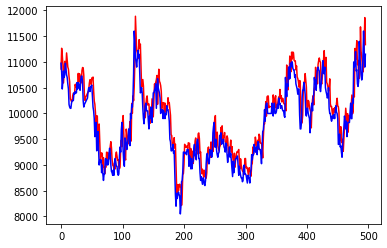

In [79]:
import pylab as pl
pl.plot(times, we, 'r')
pl.plot(times, labels[:,-1], 'b')
# pl.plot(x,y,'*k')
pl.show()
